In [8]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi
from scipy.stats import zscore

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import get_fr, popln_overlap

In [2]:
with open(pickle_dir / 'population_patterns_checks.p', 'rb') as f: 
    population_patterns = pickle.load(f)

In [102]:
with open(pickle_dir / 'place_cells_1d.p', 'rb') as f:
    place_cells = pickle.load(f)

In [114]:
to_pop = []
for k in population_patterns.keys():
    if "LMN" not in k:
        to_pop.append(k)
for k in to_pop:
    population_patterns.pop(k)

In [117]:
all_keys = [k for k in population_patterns.keys()]

In [118]:
len(all_keys)

12

In [154]:
exp_key = all_keys[2]

In [155]:
f = h5py.File(exp_key, 'r')
exp_data = ExpData(f)
c_hops = population_patterns[exp_key]['c_hops']
r_hops = population_patterns[exp_key]['r_hops']
ch_hops = population_patterns[exp_key]['ch_hops']
noncrch_hops = population_patterns[exp_key]['noncrch_hops']
hop_patterns = population_patterns[exp_key]['hop_patterns']
print(f"This experiment has {exp_data.num_neurs} neurons")

This experiment has 31 neurons


In [156]:
pl_mean_fr = place_cells[exp_key]['mean_fr']
pl_tuning_sorting = np.argsort(np.argmax(pl_mean_fr, axis=1))

## Gather Nav v Nav patterns

In [164]:
# Collect average pattern
nav_patterns = [[] for _ in range(16)]
nav_overlaps = [] # For validation
for i, noncrch1_hop in enumerate(noncrch_hops):
    noncrch1_site = exp_data.hop_end_wedges[noncrch1_hop] - 1
    if noncrch1_site == 16: continue
    if exp_data.cache_present[noncrch1_hop, noncrch1_site]: continue
    noncrch1_pattern_mat = hop_patterns[noncrch1_hop]
    for j, noncrch2_hop in enumerate(noncrch_hops):
        if j <= i: continue
        overlaps = []
        noncrch2_site = exp_data.hop_end_wedges[noncrch2_hop] - 1
        if noncrch2_site != noncrch1_site: continue
        if exp_data.cache_present[noncrch2_hop, noncrch2_site]: continue
        navig2_pattern_mat = hop_patterns[noncrch2_hop]
        overlaps = []
        overlap_patterns = []
        for navig2_pattern in navig2_pattern_mat.T:
            nav1_nav2_overlap = popln_overlap(
                noncrch1_pattern_mat, navig2_pattern
                )
            max_val = np.nanmax(nav1_nav2_overlap)
            if not np.isnan(max_val):
                max_idx = np.nanargmax(nav1_nav2_overlap)
                overlaps.append(max_val)
                overlap_patterns.append(
                    np.mean((noncrch1_pattern_mat[:,max_idx], navig2_pattern), axis=0)
                    )
        if len(overlaps) > 0:
            max_overlap = np.nanmax(overlaps)
            max_idx = np.nanargmax(overlaps)
            max_pattern = overlap_patterns[max_idx]
            nav_overlaps.append(max_overlap)
            nav_patterns[noncrch1_site].append(max_pattern)
nav_patterns = [np.mean(n_p, axis=0) for n_p in nav_patterns]
nav_patterns = np.array(nav_patterns)
nav_overlaps = np.array(nav_overlaps)
norm_nav_patterns = nav_patterns/np.sum(nav_patterns, axis=1)[:,None]
norm_nav_patterns[np.isnan(norm_nav_patterns)] = 0
nav_sorting = np.argsort(np.argmax(norm_nav_patterns, axis=0))

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: All-NaN slice encountered


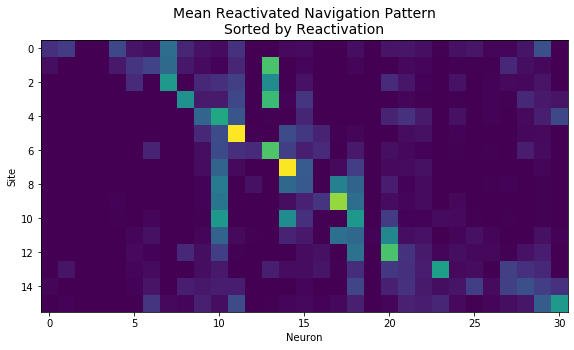

In [165]:
# Sort by reactivated nav pattern
plt.figure(figsize=(10,5))
plt.imshow(norm_nav_patterns[:,nav_sorting])
plt.xlabel("Neuron")
plt.ylabel("Site")
plt.title("Mean Reactivated Navigation Pattern\nSorted by Reactivation", fontsize=14)
plt.show()

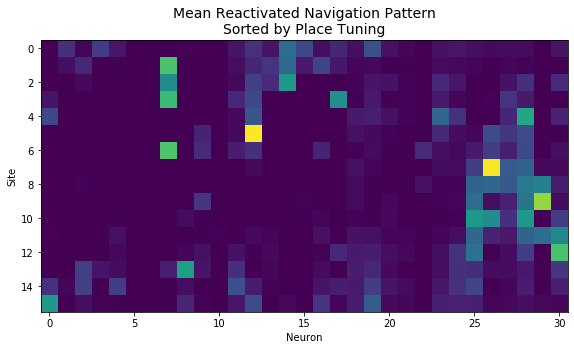

In [166]:
# Sort by place tuning
plt.figure(figsize=(10,5))
plt.imshow(norm_nav_patterns[:,pl_tuning_sorting])
plt.xlabel("Neuron")
plt.ylabel("Site")
plt.title("Mean Reactivated Navigation Pattern\nSorted by Place Tuning", fontsize=14)
plt.show()

## Gather Cache v Retriev patterns

In [160]:
# Collect average pattern
cache_patterns = [[] for _ in range(16)]
cache_overlaps = [] # For validation

for i, c_hop in enumerate(c_hops):
    c_site = int(exp_data.event_sites[exp_data.cache_event][i]) - 1
    cache_pattern_mat = hop_patterns[c_hop]
    for j, r_hop in enumerate(r_hops):
        r_site = int(exp_data.event_sites[exp_data.retriev_event][j]) - 1
        if c_site != r_site: continue
        retriev_pattern_mat = hop_patterns[r_hop]
        overlaps = []
        for retriev_pattern in retriev_pattern_mat.T:
            cache_retriev_overlap = popln_overlap(
                cache_pattern_mat, retriev_pattern
                )
            max_val = np.nanmax(cache_retriev_overlap)
            if not np.isnan(max_val):
                overlaps.append(max_val)
                max_idx = np.nanargmax(cache_retriev_overlap)
                overlaps.append(max_val)
                overlap_patterns.append(
                    np.mean((cache_pattern_mat[:,max_idx], retriev_pattern), axis=0)
                    )
        if len(overlaps) > 0:
            max_overlap = np.nanmax(overlaps)
            max_idx = np.nanargmax(overlaps)
            max_pattern = overlap_patterns[max_idx]
            cache_overlaps.append(max_overlap)
            cache_patterns[c_site].append(max_pattern)
cache_patterns = [np.nanmean(n_p, axis=0) for n_p in cache_patterns]
for i in range(16):
    if np.any(np.isnan(cache_patterns[i])):
        cache_patterns[i] = np.zeros(exp_data.num_neurs)
cache_patterns = np.array(cache_patterns)
cache_overlaps = np.array(cache_overlaps)
norm_cache_patterns = cache_patterns/np.sum(cache_patterns, axis=1)[:,None]
norm_cache_patterns[np.isnan(norm_cache_patterns)] = 0

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


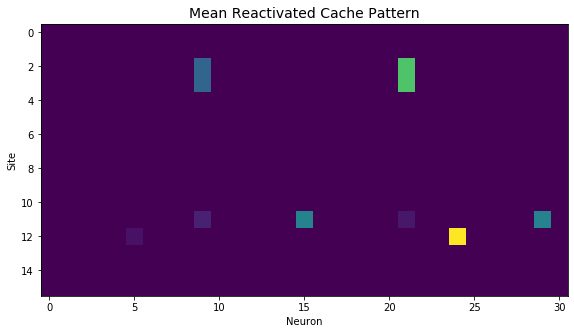

In [167]:
# Sort by reactivated nav pattern
plt.figure(figsize=(10,5))
plt.imshow(norm_cache_patterns[:,nav_sorting])
plt.xlabel("Neuron")
plt.ylabel("Site")
plt.title("Mean Reactivated Cache Pattern", fontsize=14)
plt.show()

## Gather Full Check v Retriev patterns

In [162]:
# Collect average pattern
check_patterns = [[] for _ in range(16)]
check_overlaps = [] # For validation

for i, ch_hop in enumerate(ch_hops):
    ch_site = int(exp_data.event_sites[exp_data.check_event][i]) - 1
    check_pattern_mat = hop_patterns[ch_hop]
    if not exp_data.cache_present[ch_hop, ch_site]: continue
    for j, r_hop in enumerate(r_hops):
        if ch_hop == r_hop: continue
        r_site = int(exp_data.event_sites[exp_data.retriev_event][j]) - 1
        if ch_site != r_site: continue
        retriev_pattern_mat = hop_patterns[r_hop]
        overlaps = []
        for retriev_pattern in retriev_pattern_mat.T:
            check_retriev_overlap = popln_overlap(
                check_pattern_mat, retriev_pattern
                )
            max_val = np.nanmax(check_retriev_overlap)
            if not np.isnan(max_val):
                overlaps.append(max_val)
                max_idx = np.nanargmax(check_retriev_overlap)
                overlaps.append(max_val)
                overlap_patterns.append(
                    np.mean((check_pattern_mat[:,max_idx], retriev_pattern), axis=0)
                    )
        if len(overlaps) > 0:
            max_overlap = np.nanmax(overlaps)
            max_idx = np.nanargmax(overlaps)
            max_pattern = overlap_patterns[max_idx]
            check_overlaps.append(max_overlap)
            check_patterns[ch_site].append(max_pattern)
check_patterns = [np.nanmean(n_p, axis=0) for n_p in check_patterns]
for i in range(16):
    if np.any(np.isnan(check_patterns[i])):
        check_patterns[i] = np.zeros(exp_data.num_neurs)
check_patterns = np.array(check_patterns)
check_overlaps = np.array(check_overlaps)
norm_check_patterns = check_patterns/np.sum(check_patterns, axis=1)[:,None]
norm_check_patterns[np.isnan(norm_check_patterns)] = 0

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: Mean of empty slice
/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


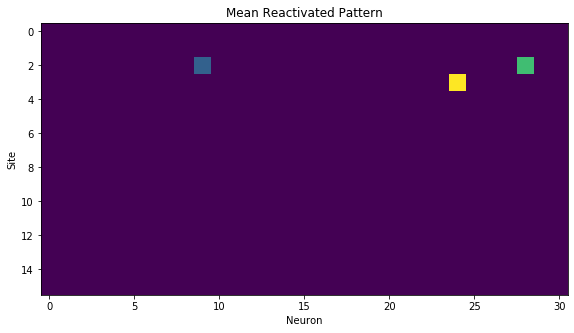

In [163]:
# Sort by reactivated nav pattern
plt.figure(figsize=(10,5))
plt.imshow(norm_check_patterns[:,nav_sorting])
plt.xlabel("Neuron")
plt.ylabel("Site")
plt.title("Mean Reactivated Pattern")
plt.show()